The following is a hierarchical bayesian model for AFL games, this model will be trained on the first 17 rounds of an AFL season, and tested on the final 6/7 rounds of the season

In [1]:
## Libraries used for model and analysis
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Step 1: Obtaining the data

The data is obtained from Kaggle: https://www.kaggle.com/datasets/stoney71/aflstats/data?select=stats.csv

Some preprocessing will need to be done to ensure it will work with the pymc model

In [2]:
games = pd.read_csv('data/games.csv')
games.head()

,GameId,Year,Round,Date,MaxTemp,MinTemp,Rainfall,Venue,StartTime,Attendance,...,HomeTeamScoreHT,HomeTeamScore3QT,HomeTeamScoreFT,HomeTeamScore,AwayTeam,AwayTeamScoreQT,AwayTeamScoreHT,AwayTeamScore3QT,AwayTeamScoreFT,AwayTeamScore
0,2012R0101,2012,R1,2012-03-24,24.0,12.2,0.0,Stadium Australia,7:20 PM,"38,203",...,3.3,3.4,5.70,37,Sydney,4.1,8.4,13.80,14.16,100
1,2012R0102,2012,R1,2012-03-29,25.7,9.7,0.0,M.C.G.,7:45 PM,"78,285",...,5.6,10.7,12.90,81,Carlton,3.2,8.7,11.13,18.17,125
2,2012R0103,2012,R1,2012-03-30,27.4,9.7,0.0,M.C.G.,7:50 PM,"78,466",...,10.6,14.1,20.17,137,Collingwood,2.7,7.9,12.16,16.19,115
3,2012R0104,2012,R1,2012-03-31,29.1,15.1,0.6,M.C.G.,1:45 PM,"33,473",...,7.4,8.8,11.12,78,Brisbane Lions,1.4,7.8,13.13,17.17,119
4,2012R0105,2012,R1,2012-03-31,28.2,19.7,0.0,Carrara,3:45 PM,"12,790",...,5.3,8.6,10.80,68,Adelaide,7.8,11.1,15.16,19.23,137


We will only keep the columns we need to avoid clutter

In [3]:
game_cols_to_keep = ['Year', 'Round', 'HomeTeam', 'HomeTeamScore', 'AwayTeam', 'AwayTeamScore']
game_df = games[game_cols_to_keep]
game_df.head()

,Year,Round,HomeTeam,HomeTeamScore,AwayTeam,AwayTeamScore
0,2012,R1,Greater Western Sydney,37,Sydney,100
1,2012,R1,Richmond,81,Carlton,125
2,2012,R1,Hawthorn,137,Collingwood,115
3,2012,R1,Melbourne,78,Brisbane Lions,119
4,2012,R1,Gold Coast,68,Adelaide,137


In [4]:
player_statistics = pd.read_csv('data/stats.csv')
player_statistics.head().columns

Index(['GameId', 'Team', 'Year', 'Round', 'PlayerId', 'DisplayName',
       'GameNumber', 'Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals',
       'Behinds', 'HitOuts', 'Tackles', 'Rebounds', 'Inside50s', 'Clearances',
       'Clangers', 'Frees', 'FreesAgainst', 'BrownlowVotes',
       'ContestedPossessions', 'UncontestedPossessions', 'ContestedMarks',
       'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists', '%Played',
       'Subs'],
      dtype='object')

The model will not analyse individual player performances, we just want team averages for each year to form a basis for 'attack' and 'defense' latent variables. Goals, goal assists and behinds will correlate too strongly with the game scores and will not provide any extra information for the model so they will be dropped. Disposals will be dropped as they are a linear combination of kicks and handballs. Variables %Played, Brownlow Votes and Subs will not be used either. These stats will be sorted into offensive and defensive metrics which is how they will be read into the model

In [5]:
cols_to_keep = ['Team', 'Year', 'Round',
       'Disposals', 'Kicks', 'Marks', 'Handballs',
       'HitOuts', 'Tackles', 'Rebounds', 'Inside50s', 'Clearances',
       'Clangers', 'Frees', 'FreesAgainst', 'ContestedPossessions', 'UncontestedPossessions', 'ContestedMarks',
       'MarksInside50', 'OnePercenters', 'Bounces']

team_stats_long = player_statistics[cols_to_keep]
rounds_to_keep = ['R' + str(i) for i in range(1,25)] #removing finals for simplicity
team_stats_long = team_stats_long[team_stats_long['Round'].isin(rounds_to_keep)]
team_stats_long.drop('Round', axis=1, inplace=True)

team_stats = team_stats_long.groupby(['Team', 'Year']).sum().sort_values(['Year', 'Team']).reset_index()
team_stats.head()

,Team,Year,Disposals,Kicks,Marks,Handballs,HitOuts,Tackles,Rebounds,Inside50s,Clearances,Clangers,Frees,FreesAgainst,ContestedPossessions,UncontestedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces
0,Adelaide,2012,7709,4793,1969,2916,981,1304,736,1163,911,944,373,397,3316,4341,283,304,1032,129
1,Brisbane Lions,2012,7716,4403,1890,3313,749,1393,817,1048,808,1097,398,446,3086,4595,204,218,1230,116
2,Carlton,2012,7853,4625,1975,3228,937,1520,651,1165,867,986,398,419,3131,4648,230,294,1128,272
3,Collingwood,2012,8198,4823,2017,3375,785,1405,784,1159,842,946,366,365,3218,4933,270,271,1088,265
4,Essendon,2012,7765,4666,2003,3099,942,1345,774,1225,798,1027,418,403,3147,4600,261,252,1094,168


In [6]:
team_stats.drop(['Team', 'Year'], axis = 1).corr()

,Disposals,Kicks,Marks,Handballs,HitOuts,Tackles,Rebounds,Inside50s,Clearances,Clangers,Frees,FreesAgainst,ContestedPossessions,UncontestedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces
Disposals,1.000000,0.910351,0.839811,0.903049,0.571414,0.789255,0.610808,0.862372,0.807113,0.582055,0.680007,0.596433,0.901822,0.969491,0.637916,0.727281,0.665613,0.337098
Kicks,0.910351,1.000000,0.911171,0.644332,0.536117,0.665195,0.705629,0.862463,0.815880,0.675174,0.701558,0.627580,0.866330,0.836495,0.694894,0.729139,0.719775,0.266493
Marks,0.839811,0.911171,1.000000,0.606178,0.483379,0.552818,0.579840,0.695572,0.652370,0.542559,0.608759,0.525762,0.675559,0.849695,0.640515,0.664675,0.514708,0.274344
Handballs,0.903049,0.644332,0.606178,1.000000,0.499480,0.768061,0.396336,0.698426,0.644660,0.374812,0.528437,0.450781,0.767312,0.923328,0.457571,0.587168,0.482929,0.346332
HitOuts,0.571414,0.536117,0.483379,0.499480,1.000000,0.600626,0.285175,0.512277,0.708788,0.204307,0.452939,0.359242,0.634800,0.503586,0.488756,0.422544,0.311608,0.214313
Tackles,0.789255,0.665195,0.552818,0.768061,0.600626,1.000000,0.424493,0.709848,0.755650,0.357743,0.545966,0.552527,0.825077,0.720601,0.511500,0.590045,0.587356,0.351427
Rebounds,0.610808,0.705629,0.579840,0.396336,0.285175,0.424493,1.000000,0.483696,0.531633,0.841321,0.583252,0.646899,0.583790,0.525661,0.421032,0.278173,0.582944,0.027090
Inside50s,0.862372,0.862463,0.695572,0.698426,0.512277,0.709848,0.483696,1.000000,0.797782,0.567436,0.623790,0.576188,0.891526,0.768696,0.675053,0.862492,0.699808,0.292668
Clearances,0.807113,0.815880,0.652370,0.644660,0.708788,0.755650,0.531633,0.797782,1.000000,0.435312,0.626129,0.558520,0.877533,0.698812,0.559309,0.633563,0.673268,0.357811
Clangers,0.582055,0.675174,0.542559,0.374812,0.204307,0.357743,0.841321,0.567436,0.435312,1.000000,0.614480,0.735799,0.557747,0.504727,0.412057,0.387999,0.579595,-0.118877


Clearly a lot of the stats are highly correlated which will justify the use of PCA on the dataset

In [7]:
def pca(team_statistics_dataset):
    
    teams = team_statistics_dataset['Team']
    years = team_statistics_dataset['Year']

    team_stats = team_statistics_dataset.drop(['Team', 'Year'], axis = 1)

    # Standardize the data
    scaler = StandardScaler()
    team_stats_scaled = scaler.fit_transform(team_stats)

    # Fit the PCA model
    pca = PCA(n_components = 0.95) # To retain 95% of the variance
    new_data = pca.fit_transform(team_stats_scaled)

    # Format the pca data into a dataframe

    pca_data = pd.DataFrame(new_data, columns = ['PC' + str(i) for i in range(1, new_data.shape[1] + 1)])
    pca_data['Team'] = teams
    pca_data['Year'] = years
    final_columns = ['Team', 'Year'] + ['PC' + str(i) for i in range(1, new_data.shape[1] + 1)]
    pca_data = pca_data[final_columns]
       
    return pca_data

PCA_stats = pca(team_stats)
PCA_stats

,Team,Year,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,Adelaide,2012,0.658792,-0.984249,2.014072,0.701787,-1.409568,-0.106361,-0.790861,-0.232091,0.094558
1,Brisbane Lions,2012,-0.074597,1.021397,-1.181794,0.554890,-0.257283,-0.932035,-0.211187,0.481955,-0.058517
2,Carlton,2012,0.931581,-1.997261,-0.396465,0.516284,-1.557807,-0.147811,0.164286,-0.080944,-0.745708
3,Collingwood,2012,0.936581,-1.732937,-0.196525,-0.739634,-1.171677,0.274340,-0.534968,0.162109,1.026016
4,Essendon,2012,0.687605,-0.341206,0.705276,0.461726,-0.934017,0.173532,-0.230057,0.392014,0.089700
...,...,...,...,...,...,...,...,...,...,...,...
211,Richmond,2023,2.337820,1.487335,-0.185844,-0.374654,-0.952431,-0.078276,-1.424848,-1.872549,0.505720
212,St Kilda,2023,2.673075,1.001132,-0.171502,-1.805777,1.210700,0.351236,-0.825929,0.307152,0.317417
213,Sydney,2023,2.363447,1.790445,-0.776916,-0.237490,-0.693070,-0.835622,-0.132525,-0.307637,0.319752
214,West Coast,2023,-0.372962,1.529812,-1.414003,-0.161040,1.629578,0.757098,-0.364209,-0.715334,-0.339356


We will create a data class to organise all constant data for the pymc model, including variables that will inform the parameters of our prior distributions. The model will only analyse one year at a time so the season will be a parameter for the data class

In [8]:
class Data:
    def __init__(self, game_df, team_stats_df, season, rounds = 23):
        rounds = ['R' + str(i) for i in range(1, rounds + 1)]
        self.game_df = game_df.loc[(game_df['Year'] == season) & (game_df['Round'].isin(rounds))].reset_index(drop=True)
        self._add_winner_column()
        self.team_stats_df = team_stats_df.loc[team_stats_df['Year'] == season].reset_index(drop = True)
        self._infer_statistics()
        self.coords = {"team": self.teams,
                       "metric": self.team_stats_df.drop(['Team', 'Year'], axis = 1).columns,
                       "match": self.game_df.index}
        self._priors()

    def _infer_statistics(self):
        self.home_idx, self.teams = pd.factorize(self.game_df["HomeTeam"], sort=True)
        self.away_idx, _ = pd.factorize(self.game_df["AwayTeam"], sort=True)

    def _priors(self):
        ratio = self.game_df["HomeTeamScore"] / self.game_df["AwayTeamScore"]
        self.avg_home_point_advantage = ratio.mean()
        self.home_point_advantage_std = ratio.std()
        all_scores = np.array(pd.concat([self.game_df["HomeTeamScore"], self.game_df["AwayTeamScore"]]))
        self.avg_score = np.mean(all_scores)
        self.score_std = np.std(all_scores)

    def _add_winner_column(self):
        self.game_df["Winner"] = self.game_df.apply(lambda x: x["HomeTeam"] if x["HomeTeamScore"] > x["AwayTeamScore"] else x["AwayTeam"], axis=1)

data = Data(game_df, PCA_stats, 2017, rounds = 23)
    

The pymc model.

The model will attempt to learn latent attack and defense paramters for each team. These parameters will be formed by a linear regression of the team statistics variables, as well as a team specific intercept term to capture information that leads to a teams score that is not captured by the variables in team statistics. 

The scoring is modelled by a normal distribution rather than a typical poisson distribution to better account for the higher spread in points scored

In [9]:
def create_model(data):

    with pm.Model(coords = data.coords) as model:

        #constant data
        home_team = pm.ConstantData('home_team', data.home_idx, dims = "match")
        away_team = pm.ConstantData('away_team', data.away_idx, dims = "match")

        team_statistics = pm.ConstantData('team_statistics', data.team_stats_df.drop(['Team', 'Year'], axis = 1).values, dims = ["team", "metric"])

        #global model parameters
        home_uncentered = pm.Normal('home_uncentered', mu = 0, sigma = 1)
        home = pm.Deterministic('home', home_uncentered * np.log(data.home_point_advantage_std) + np.log(data.avg_home_point_advantage))

        scoring_intercept_uncentered = pm.Normal('scoring_intercept_uncentered', mu = 0, sigma = 1)
        scoring_intercept = pm.Deterministic('scoring_intercept', scoring_intercept_uncentered * np.log(data.score_std) + np.log(data.avg_score))

        #team-specific model parameters
        att_beta = pm.ZeroSumNormal('att_beta', sigma = 0.05, dims = "metric")
        offensive_intercept = pm.Normal('offensive_intercept', mu = 0, sigma = 1, dims="team")
        atts_star = pm.Deterministic('atts_star', pm.math.dot(att_beta, team_statistics.T) + offensive_intercept, dims = "team")

        def_beta = pm.ZeroSumNormal('def_beta', sigma = 0.05, dims = "metric")
        defensive_intercept = pm.Normal('defensive_intercept', mu = 0, sigma = 1, dims="team")
        defs_star = pm.Deterministic('defs_star', pm.math.dot(def_beta, team_statistics.T) + defensive_intercept, dims = "team")

        atts = pm.Deterministic('atts', atts_star - pt.mean(atts_star), dims = "team")
        defs = pm.Deterministic('defs', defs_star - pt.mean(defs_star), dims = "team")

        #scoring
        home_mu = pt.exp(scoring_intercept + home + atts[home_team] - defs[away_team])
        away_mu = pt.exp(scoring_intercept + atts[away_team] - defs[home_team])

        sigma_uncentered = pm.Exponential("sigma_uncentered", scale = 1, dims = "team")
        sigma = pm.Deterministic("sigma", sigma_uncentered * np.log(data.score_std), dims = "team")

        home_points = pm.Normal("home_points",
                                mu = home_mu,
                                sigma = sigma[home_team],
                                observed = data.game_df["HomeTeamScore"],
                                dims = "match")
        
        away_points = pm.Normal("away_points",
                                mu = away_mu,
                                sigma = sigma[away_team],
                                observed = data.game_df["AwayTeamScore"],
                                dims = "match")
        
        trace = pm.sample(draws = 1000,
                        tune = 5000,
                        chains = 4,
                        cores = 4,)
        
    return trace

trace = create_model(data)
az.to_netcdf(trace, 'trace.nc') #save trace for later use

/Users/jedtoner1/Desktop/Developer/AFLSeason/AFL/lib/python3.12/site-packages/pymc/data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/Users/jedtoner1/Desktop/Developer/AFLSeason/AFL/lib/python3.12/site-packages/pymc/data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home_uncentered, scoring_intercept_uncentered, att_beta, offensive_intercept, def_beta, defensive_intercept, sigma_uncentered]


/Users/jedtoner1/Desktop/Developer/AFLSeason/AFL/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 53 seconds.


'trace.nc'

We will look at plots and diagnostics to see if our model has converged

In [10]:
trace = az.from_netcdf('trace.nc') #load model trace

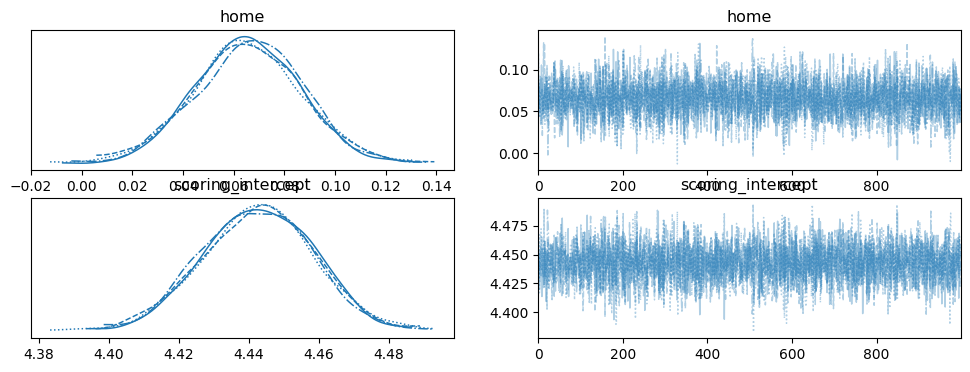

In [11]:
az.plot_trace(trace, var_names = ["home", "scoring_intercept"]);

In [12]:
az.summary(trace, var_names = ["atts", "defs"], kind = "diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
atts[Adelaide],0.001,0.001,4116.0,3077.0,1.0
atts[Brisbane Lions],0.001,0.000,4238.0,3662.0,1.0
atts[Carlton],0.001,0.000,3784.0,3666.0,1.0
atts[Collingwood],0.001,0.000,4000.0,3781.0,1.0
atts[Essendon],0.001,0.001,3959.0,3120.0,1.0
atts[Fremantle],0.001,0.001,3855.0,2945.0,1.0
atts[Geelong],0.001,0.000,4149.0,3120.0,1.0
atts[Gold Coast],0.001,0.001,3879.0,2968.0,1.0
atts[Greater Western Sydney],0.001,0.000,4075.0,3086.0,1.0
atts[Hawthorn],0.001,0.001,4026.0,3041.0,1.0


Our model has converged and Rhat looks good.

We will now inspect the parameters to see if they match up with industry knowledge. The 2017 season saw Adelaide, Richmond, Geelong do well and Carlton, Gold Coast and Brisbane do poorly

In [13]:
trace.posterior["atts"].mean(dim = ["chain", "draw"]).to_pandas().sort_values()

team
Carlton                  -0.205138
Fremantle                -0.193383
Gold Coast               -0.112112
Western Bulldogs         -0.057072
Hawthorn                 -0.051424
Brisbane Lions           -0.020016
St Kilda                 -0.013627
Collingwood              -0.000820
Richmond                  0.000670
North Melbourne           0.005767
West Coast                0.007059
Melbourne                 0.024026
Essendon                  0.060009
Sydney                    0.070289
Greater Western Sydney    0.087530
Port Adelaide             0.089931
Geelong                   0.093058
Adelaide                  0.215254
dtype: float64

In [14]:
trace.posterior["defs"].mean(dim = ["chain", "draw"]).to_pandas().sort_values()

team
Brisbane Lions           -0.261642
Gold Coast               -0.182726
North Melbourne          -0.161610
Fremantle                -0.086852
Carlton                  -0.034198
Essendon                 -0.024289
St Kilda                 -0.017908
Hawthorn                 -0.010141
Collingwood               0.002900
Melbourne                 0.005190
Western Bulldogs          0.033926
West Coast                0.058964
Geelong                   0.087093
Greater Western Sydney    0.088482
Adelaide                  0.091281
Sydney                    0.132509
Richmond                  0.135809
Port Adelaide             0.143211
dtype: float64

So the model parameters recover what we already knew about the 2017 season. Lets plot the latent variables for each team

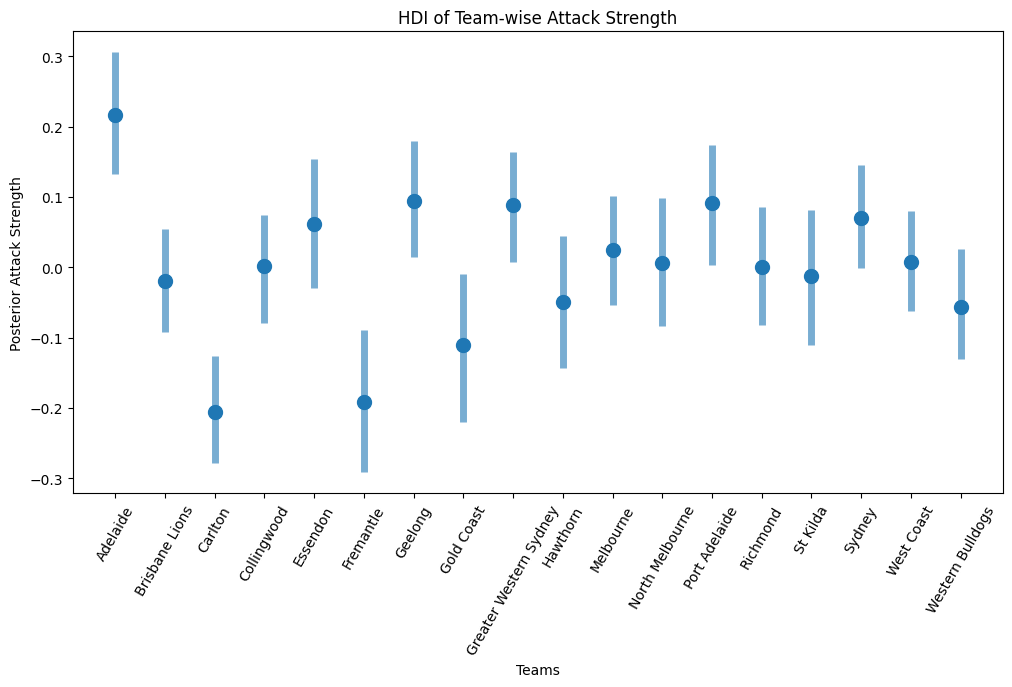

In [15]:
trace_hdi = az.hdi(trace)

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(data.teams, trace.posterior["atts"].median(dim=("chain", "draw")), color="C0", alpha=1, s=100)
ax.vlines(
    data.teams,
    trace_hdi["atts"].sel({"hdi": "lower"}),
    trace_hdi["atts"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
ax.set_xticks(range(len(data.teams)))
ax.set_xticklabels(data.teams, rotation=60);
ax.set_xlabel("Teams")
ax.set_ylabel("Posterior Attack Strength")
ax.set_title("HDI of Team-wise Attack Strength");

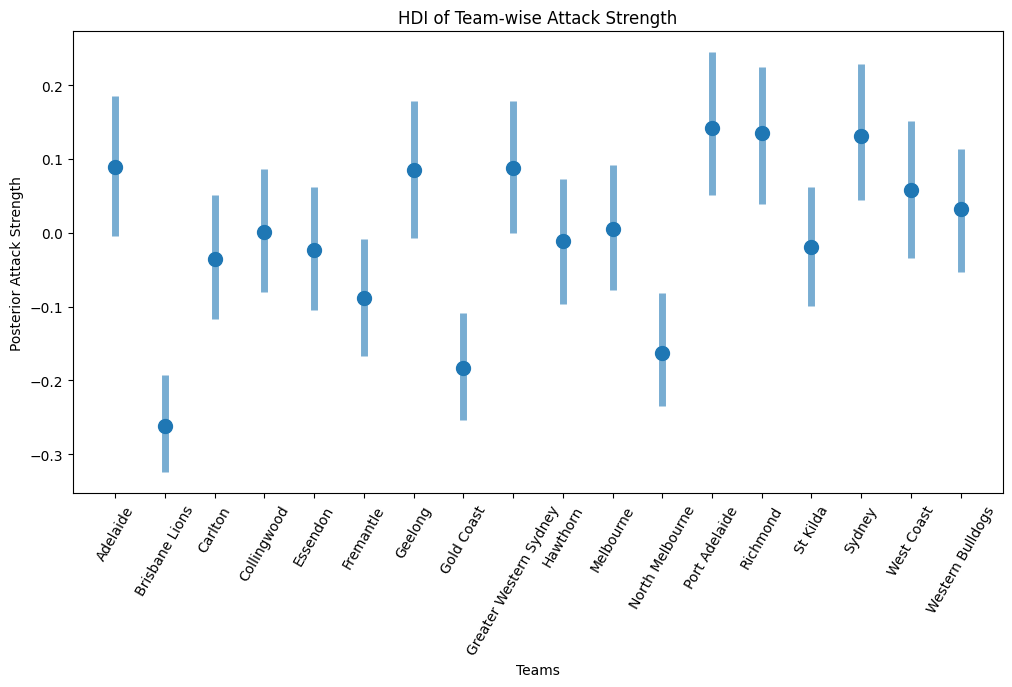

In [16]:
trace_hdi = az.hdi(trace)

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(data.teams, trace.posterior["defs"].median(dim=("chain", "draw")), color="C0", alpha=1, s=100)
ax.vlines(
    data.teams,
    trace_hdi["defs"].sel({"hdi": "lower"}),
    trace_hdi["defs"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
ax.set_xticks(range(len(data.teams)))
ax.set_xticklabels(data.teams, rotation=60);
ax.set_xlabel("Teams")
ax.set_ylabel("Posterior Attack Strength")
ax.set_title("HDI of Team-wise Attack Strength");

We will build functions to predict the outcome of games and probability of winning

In [17]:
def predict_game(home_team, away_team, trace, variance = True):
    
    post = trace.posterior

    home = post["home"].mean()
    scoring_intercept = post["scoring_intercept"].mean()
    atts = post["atts"].mean(dim = ["chain", "draw"])
    defs = post["defs"].mean(dim = ["chain", "draw"])

    home_mu = np.exp(scoring_intercept + home + atts.sel(team = home_team) - defs.sel(team = away_team)).values
    away_mu = np.exp(scoring_intercept + atts.sel(team = away_team) - defs.sel(team = home_team)).values

    if variance:
        sigma = post["sigma"].mean(dim = ["chain", "draw"]).sel(team = home_team)
        home_points = np.random.normal(home_mu, sigma)
        sigma = post["sigma"].mean(dim = ["chain", "draw"]).sel(team = away_team)
        away_points = np.random.normal(away_mu, sigma)
    else:
        home_points = home_mu
        away_points = away_mu

    return (home_team, home_points, away_team, away_points)

def predict_winner(home_team, away_team, trace):
    home_team, home_points, away_team, away_points = predict_game(home_team, away_team, trace, variance = False)
    return home_team if home_points > away_points else away_team


predict_game("Richmond", "Adelaide", trace, variance=False)

('Richmond', array(82.89362002), 'Adelaide', array(92.0250401))

Lets test the in sample accuracy for predicting the winner of games

In [18]:
trace = az.from_netcdf('trace.nc') #load model trace

In [19]:
games_2017 = games.loc[games["Year"] == 2017].reset_index(drop=True)
games_2017 = games_2017[~games_2017["Round"].str.contains("F")] #remove finals
games_2017['Winner'] = games_2017.apply(lambda x: x["HomeTeam"] if x["HomeTeamScore"] > x["AwayTeamScore"] else x["AwayTeam"], axis=1)
games_2017['Predicted Winner'] = games_2017.apply(lambda x: predict_winner(x["HomeTeam"], x["AwayTeam"], trace), axis=1)
accuracy = (games_2017["Winner"] == games_2017["Predicted Winner"]).mean()
print(accuracy)

0.702020202020202


So we have a 70% in sample accuracy. Lets retrain a model on 2022 data to test the out of sample accuracy for the last 7 rounds of the season

We will have to reconstruct the team stats principal components as we can only take into account the first 17 rounds of the season, an assumption used here is that the team stats for the first 17 rounds can be scaled up by an appropriate factor to get the team stats for the whole 23 round season

In [20]:
# Load player statistics
player_statistics = pd.read_csv('data/stats.csv')
player_statistics = player_statistics.loc[player_statistics['Year'] <= 2022].reset_index(drop=True)

# Columns to keep
cols_to_keep = ['Team', 'Year', 'Round',
       'Disposals', 'Kicks', 'Marks', 'Handballs',
       'HitOuts', 'Tackles', 'Rebounds', 'Inside50s', 'Clearances',
       'Clangers', 'Frees', 'FreesAgainst', 'ContestedPossessions', 'UncontestedPossessions', 'ContestedMarks',
       'MarksInside50', 'OnePercenters', 'Bounces']

# Filter the DataFrame to keep only the necessary columns
team_stats_long = player_statistics[cols_to_keep]

# Define rounds to keep (excluding finals for simplicity)
rounds_to_keep = ['R' + str(i) for i in range(1, 25)]  # R1 to R24
first_17_rounds = ['R' + str(i) for i in range(1, 18)]  # R1 to R17

# Filter the DataFrame to include only the specified rounds
team_stats_long = team_stats_long[team_stats_long['Round'].isin(rounds_to_keep)]

# Drop rows where Year is 2022 and Round is 17 or before
team_stats_long = team_stats_long[~((team_stats_long['Year'] == 2022) & ~team_stats_long['Round'].isin(first_17_rounds))]

team_stats_long.drop('Round', axis=1, inplace=True)

team_stats = team_stats_long.groupby(['Team', 'Year']).sum().sort_values(['Year', 'Team']).reset_index()
       
stat_cols = team_stats.select_dtypes(include='number').columns.drop('Year')
team_stats[stat_cols] = team_stats[stat_cols].astype(float)
team_stats.loc[team_stats['Year'] == 2022, stat_cols] *= (23/17) # Scale the 2022 stats to 23 rounds

PCA_stats = pca(team_stats)

data = Data(game_df, PCA_stats, 2022, rounds=17)

In [21]:
trace = create_model(data)
az.to_netcdf(trace, 'trace_2022.nc') #save trace for later use

/Users/jedtoner1/Desktop/Developer/AFLSeason/AFL/lib/python3.12/site-packages/pymc/data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/Users/jedtoner1/Desktop/Developer/AFLSeason/AFL/lib/python3.12/site-packages/pymc/data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home_uncentered, scoring_intercept_uncentered, att_beta, offensive_intercept, def_beta, defensive_intercept, sigma_uncentered]


/Users/jedtoner1/Desktop/Developer/AFLSeason/AFL/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 47 seconds.


'trace_2022.nc'

In [22]:
trace = az.from_netcdf('trace_2022.nc')

In [23]:
games_2022 = games.loc[games["Year"] == 2022].reset_index(drop=True)
games_2022 = games_2022[~games_2022["Round"].str.contains("F")] #remove finals
games_2022['Winner'] = games_2022.apply(lambda x: x["HomeTeam"] if x["HomeTeamScore"] > x["AwayTeamScore"] else x["AwayTeam"], axis=1)
games_2022['Predicted Winner'] = games_2022.apply(lambda x: predict_winner(x["HomeTeam"], x["AwayTeam"], trace), axis=1)
test_rounds = [f'R{i}' for i in range(18, 24)]
test_games = games_2022[games_2022['Round'].isin(test_rounds)]
accuracy = (test_games["Winner"] == test_games["Predicted Winner"]).mean()
print(accuracy)

0.8148148148148148


Surprisingly greater than the in sample accuracy for 2017, this could be due to 2022 being a more predictable season. Nonetheless a good result

Possible area for improvement:

 - Implement form tracking - perhaps by time varying coefficients or a 'form' variable measuring effectiveness over past 5 games
 - Player level modelling - quantifying the contribution of each player to the team. This could form the basis of models spanning over multiple years and tracking player movement
 - Implementing variables such as weather, crowd impact and better handling of home advantage - perhaps specific to city or team
 - Tracking more advanced statistics that may have a higher impact on games, these might include meters gained, hard ball gets, broken tackles
 - Better handling/modelling of scoring sources - these include scoring from stoppage, kick ins and tunrover